# Simple forecasting of COVID-19 using exponential and sigmoid functions

This repo uses report COVID-19 data provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) to estimate near term COVID-19 death rates around the world.  


In [24]:
# COVID-19 forecasting - how will this impact NZ and NZ electricity demand in 2020?
import pandas as pd
%pylab inline
from datetime import date, datetime, time, timedelta
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
# get some nice colours and define better legend and plot formatting...

c_p = {'rd2': (0.9647058823529412, 0.5450980392156862, 0.6352941176470588), 'yl1': (1.0, 0.7294117647058823, 0.17647058823529413), 'gy2': (0.9098039215686274, 0.9098039215686274, 0.9098039215686274), 'bl2': (0.7176470588235294, 0.8901960784313725, 0.9725490196078431), 'yl2': (0.984313725490196, 0.8196078431372549, 0.5450980392156862), 'br1': (0.32941176470588235, 0.0, 0.0), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'rd1': (0.9294117647058824, 0.09019607843137255, 0.27058823529411763), 'gy1': (0.8235294117647058, 0.8235294117647058, 0.8235294117647058), 'br2': (0.6627450980392157, 0.5019607843137255, 0.5019607843137255)}
c_s = {'og1': (0.8235294117647058, 0.38823529411764707, 0.10196078431372549), 'yl1': (0.803921568627451, 0.8156862745098039, 0.0), 'or1': (1.0, 0.4823529411764706, 0.0), 'pp1': (0.27058823529411763, 0.1803921568627451, 0.6745098039215687), 'mv1': (0.0, 0.4588235294117647, 0.4235294117647059), 'rd2': (0.8470588235294118, 0.5882352941176471, 0.5019607843137255), 'pr1': (0.803921568627451, 0.34901960784313724, 1.0), 'pk2': (1.0, 0.7372549019607844, 0.8313725490196079), 'gr1': (0.00784313725490196, 0.4666666666666667, 0.2196078431372549), 'or2': (1.0, 0.7372549019607844, 0.5019607843137255), 'mv2': (0.5019607843137255, 0.7254901960784313, 0.7098039215686275), 'pp2': (0.6862745098039216, 0.6431372549019608, 0.7411764705882353), 'gn1': (0.3803921568627451, 0.7372549019607844, 0.22745098039215686), 'bu1': (0.0, 0.5568627450980392, 1.0), 'bl2': (0.5254901960784314, 0.7372549019607844, 0.8392156862745098), 'ge1': (0.0, 0.7019607843137254, 0.6196078431372549), 'yl2': (0.8980392156862745, 0.9058823529411765, 0.5019607843137255), 'bu2': (0.5019607843137255, 0.7725490196078432, 1.0), 'ge2': (0.5019607843137255, 0.8470588235294118, 0.807843137254902), 'rd1': (0.7019607843137254, 0.18823529411764706, 0.0), 'gy1': (0.5843137254901961, 0.5843137254901961, 0.5843137254901961), 'og2': (0.8901960784313725, 0.6901960784313725, 0.5490196078431373), 'gy2': (0.788235294117647, 0.788235294117647, 0.788235294117647), 'be2': (0.8862745098039215, 0.9490196078431372, 0.984313725490196), 'pk1': (1.0, 0.3411764705882353, 0.9607843137254902), 'be1': (0.7803921568627451, 0.9019607843137255, 0.9803921568627451), 'gr2': (0.5019607843137255, 0.7294117647058823, 0.7098039215686275), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'gn2': (0.6862745098039216, 0.8666666666666667, 0.611764705882353), 'pr2': (0.8980392156862745, 0.6705882352941176, 1.0)}

def colours():
    mpl.rcParams['axes.prop_cycle'] = cycler('color', [c_p['br1'], c_p['br2'],
        c_p['bl1'], c_p['bl2'], c_p['yl1'], c_p['yl2'], c_p['rd1'], c_p['rd2'],
        c_p['gy1'], c_p['gy2'], c_s['pp1'], c_s['pp2'], c_s['pr1'], c_s['pr2'],
        c_s['gr1'], c_s['gr2'], c_s['gn1'], c_s['gn2'], c_s['pk1'], c_s['pk2'],
        c_s['yl1'], c_s['yl2'], c_s['mv1'], c_s['mv2']])

def legend_format(ax, cols=4, xpos=-0.021, ypos=-0.15, **kwargs):
    """Place legend outside of plot"""
    ax.legend(loc=3,
              bbox_to_anchor=(xpos, ypos),
              ncol=cols,
              frameon=False, **kwargs)

def plot_formatting(ax, rot=False, **kwargs):
    """A few tricks used for better looking plots"""
    ax.grid(b=True, which='major', color='k', linestyle='-',
            axis='y', alpha=0.6, clip_on=True, marker=None)
    ax.grid(b=False, axis='x', which='both')
    ax.set_frame_on(False)  # Remove plot frame
    ax.set_axisbelow(True)
    ax.xaxis.tick_bottom()
    plt.xticks(ax.get_xticks(), rotation=0, **kwargs)
    if rot:
        plt.xticks(ax.get_xticks(), rotation=90, **kwargs)
    else:
        plt.xticks(ax.get_xticks(), rotation=0, **kwargs) 
    
colours()

In [26]:
# Update data from the Johns Hopkins University Center for Systems Science and
# Engineering (JHU CSSE) github repo
#!git pull upstream master

In [4]:
# Read into Pandas DataFrames
d_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv', index_col=[0, 1, 2, 3], parse_dates=True)
c_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv', index_col=[0, 1, 2, 3], parse_dates=True)
r_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv', index_col=[0, 1, 2, 3], parse_dates=True)

# Convert columns to datetime objects
d_ts.columns = pd.to_datetime(d_ts.columns)
c_ts.columns = pd.to_datetime(c_ts.columns)
r_ts.columns = pd.to_datetime(c_ts.columns)

# China
C_D = d_ts.groupby(level=1, axis=0).sum().T["China"]
C_C = c_ts.groupby(level=1, axis=0).sum().T["China"]
C_R = r_ts.groupby(level=1, axis=0).sum().T["China"]

# RoW
RoW_D = d_ts.groupby(level=1, axis=0).sum().T.drop('China', axis=1).sum(axis=1)
RoW_C = c_ts.groupby(level=1, axis=0).sum().T.drop('China', axis=1).sum(axis=1)
RoW_R = r_ts.groupby(level=1, axis=0).sum().T.drop('China', axis=1).sum(axis=1)


RoW_D2 = d_ts.groupby(level=1, axis=0).sum().T.drop('China', axis=1)
RoW_D2.loc['2020-03-12', 'Italy']=np.nan
RoW_D2 = RoW_D2.interpolate()
RoW_D = RoW_D2.sum(axis=1)

In [5]:
def fit_exp(df, start_date=datetime(2020, 1, 21), end_date=datetime(2020, 4, 20)):
    """Simple exponential forecast - essentially a straight line fit of the logs.
       This massively over estimates things in the long run but may be reasonably 
       accurate while in the early exponential phase of a pandemic.  It is still good to
       use to help see when we are deviating from the exponential"""
    def initialise_forecast(df, start_date=start_date, end_date=end_date):
        """given actual reported death rate data, start time, and forecast end time, return cropped reported data and forecast date range for forecasting"""
        df = df[start_date:]
        df = df.replace(0, np.nan).dropna()
        dates = list(df.index)
        date_forecast = pd.date_range(start_date, end_date).to_pydatetime()
        x = mdates.date2num(dates)
        x_forecast = mdates.date2num(date_forecast)
        return df, dates, x, x_forecast

    df, dates, x, x_forecast = initialise_forecast(df, start_date=start_date, end_date=end_date)
    ydata = df.values
    df_reported = pd.DataFrame({'Date': x, 'Reported': ydata})
    df_reported.set_index('Date', inplace=True)

    y = log(ydata)
    p4 = np.poly1d(np.polyfit(x, y, 1))

    xx = np.linspace(x.min(), x.max(), 100)
    xx_forecast = np.linspace(x_forecast.min(), x_forecast.max(), 1000)
    dd = mdates.num2date(xx)
    dd_forecast = mdates.num2date(xx_forecast)

    df = pd.DataFrame({'Date': dd, 'Fitted': exp(p4(xx))})
    df_reported = pd.DataFrame({'Date': dates, 'Reported': ydata})
    df.set_index('Date', inplace=True)
    df_reported.set_index('Date', inplace=True)
    df_forecast = pd.DataFrame({'Date': dd_forecast,
                                'Forecast': exp(p4(xx_forecast))})
    df_forecast.set_index('Date', inplace=True)
    df_forecast.index = df_forecast.index.map(lambda x: x.date())
    df_forecast = df_forecast.groupby(level=0).min()
    df_p = pd.DataFrame({'Reported': df_reported.Reported,
                        'Forecast': df_forecast.Forecast}, index=df_forecast.index)

    df_p.index = pd.to_datetime(df_p.index)
    return df_p

In [6]:
# define some functions we will use to curve fit and forecast COVID-19 deaths...

def fit_sigmoid(df, start_date=datetime(2020, 1, 21), end_date=datetime(2020, 3, 31),
                p0=None):
    """Attempt to fit a sigmoid function to actual data, the outputs (popt, pcov) 
       are then used in forecast..."""

    def sigmoid(x, L ,x0, k, b):
        """https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python"""
        y = L / (1 + np.exp(-k*(x-x0)))+b
        return (y)

    def initialise_forecast(df, start_date=start_date, end_date=end_date):
        """given actual reported death rate data, start time, and forecast end time, return cropped reported data and forecast date range for forecasting"""
        df = df[start_date:]
        dates = list(df.index)
        date_forecast = pd.date_range(start_date, end_date).to_pydatetime()
        x = mdates.date2num(dates)
        x_forecast = mdates.date2num(date_forecast)
        return df, x, x_forecast

    df, x, x_forecast = initialise_forecast(df, start_date=start_date, end_date=end_date)
    dates = list(df.index)
    xdata = mdates.date2num(dates)
    ydata = df.values
    df_reported = pd.DataFrame({'Date': dates, 'Reported': ydata})
    df_reported.set_index('Date', inplace=True)

    if not p0:
        p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    print(p0)
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
    
    y_forecast = sigmoid(x_forecast, *popt)
    
    xx_forecast = pd.to_datetime(mdates.num2date(x_forecast))
    xx_forecast = xx_forecast.map(lambda x: x.date())

    
    
    df_p = pd.DataFrame({'Forecast': y_forecast, 
                        'Reported': df_reported.Reported}, index=xx_forecast)
    df_p.index = pd.to_datetime(df_p.index)
    return df_p  #y_forecast, xx_forecast


### China death rate data follows a sigmoid (S-curve function)

https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python

https://en.wikipedia.org/wiki/Logistic_function

We need to fit to this, then apply to the RoW data.

Chinese data looks like topping out at <4000 total deaths.  

But China was aggressive with containment, so this might be a best case scenario when applied to the rest of the world.


[3217, 737473.0, 1, 17]
[3217, 737473.0, 1, 17]
[3217, 737473.0, 1, 17]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


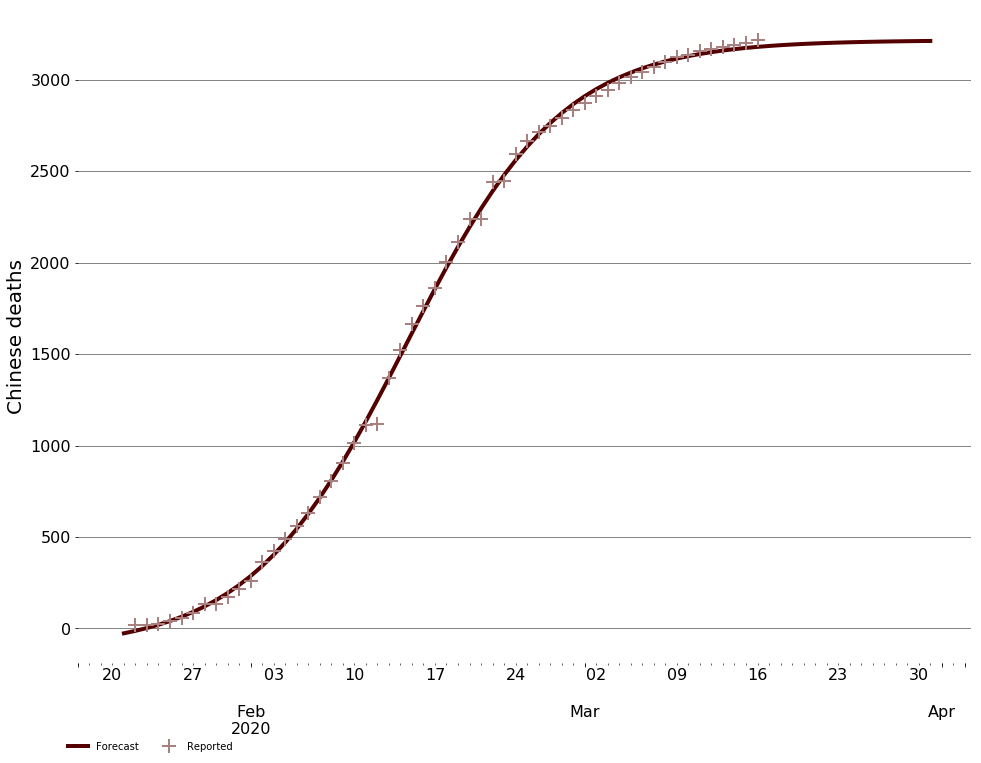

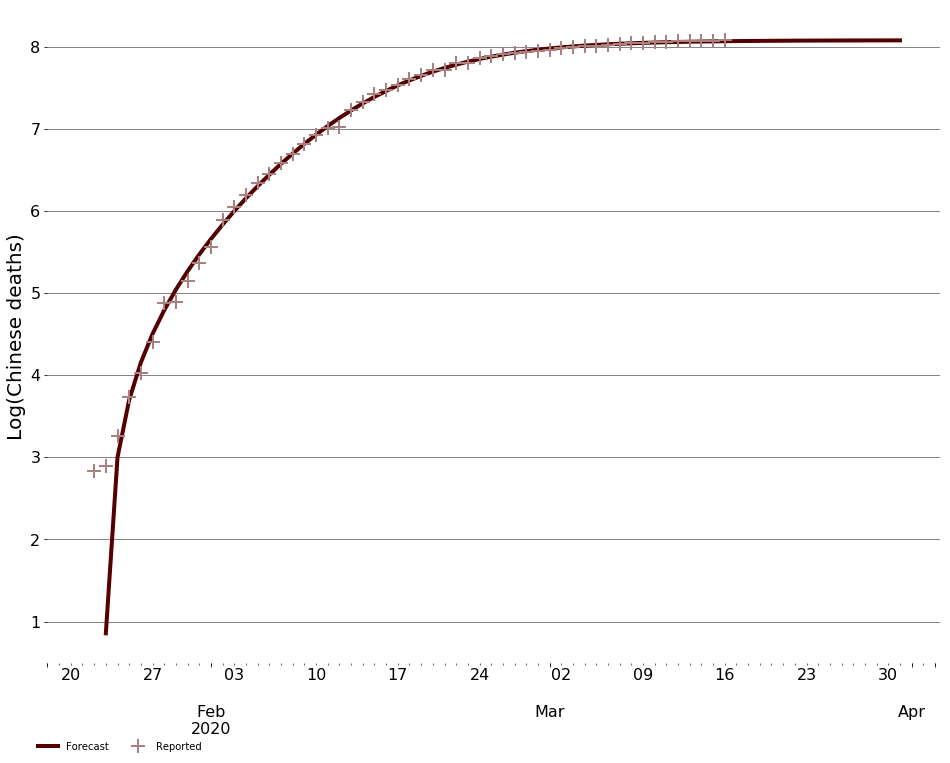

In [8]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
C_D_fitted = fit_sigmoid(C_D)
C_D_fitted.Forecast.plot(ax=ax, lw=4, fontsize=16, label='Forecast')
C_D_fitted.Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2, label='Reported')
grid('on')
ax.set_ylabel('Chinese deaths', fontsize=20)
legend_format(ax)
plot_formatting(ax)

fig = plt.figure(2, figsize=[16,12])
ax = fig.add_subplot(111)
log(fit_sigmoid(C_D).Forecast).plot(ax=ax, lw=4, fontsize=16)
log(fit_sigmoid(C_D).Reported).plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
ax.set_ylabel('Log(Chinese deaths)', fontsize=20)
grid('on')

legend_format(ax)
plot_formatting(ax)

## Rest of World data

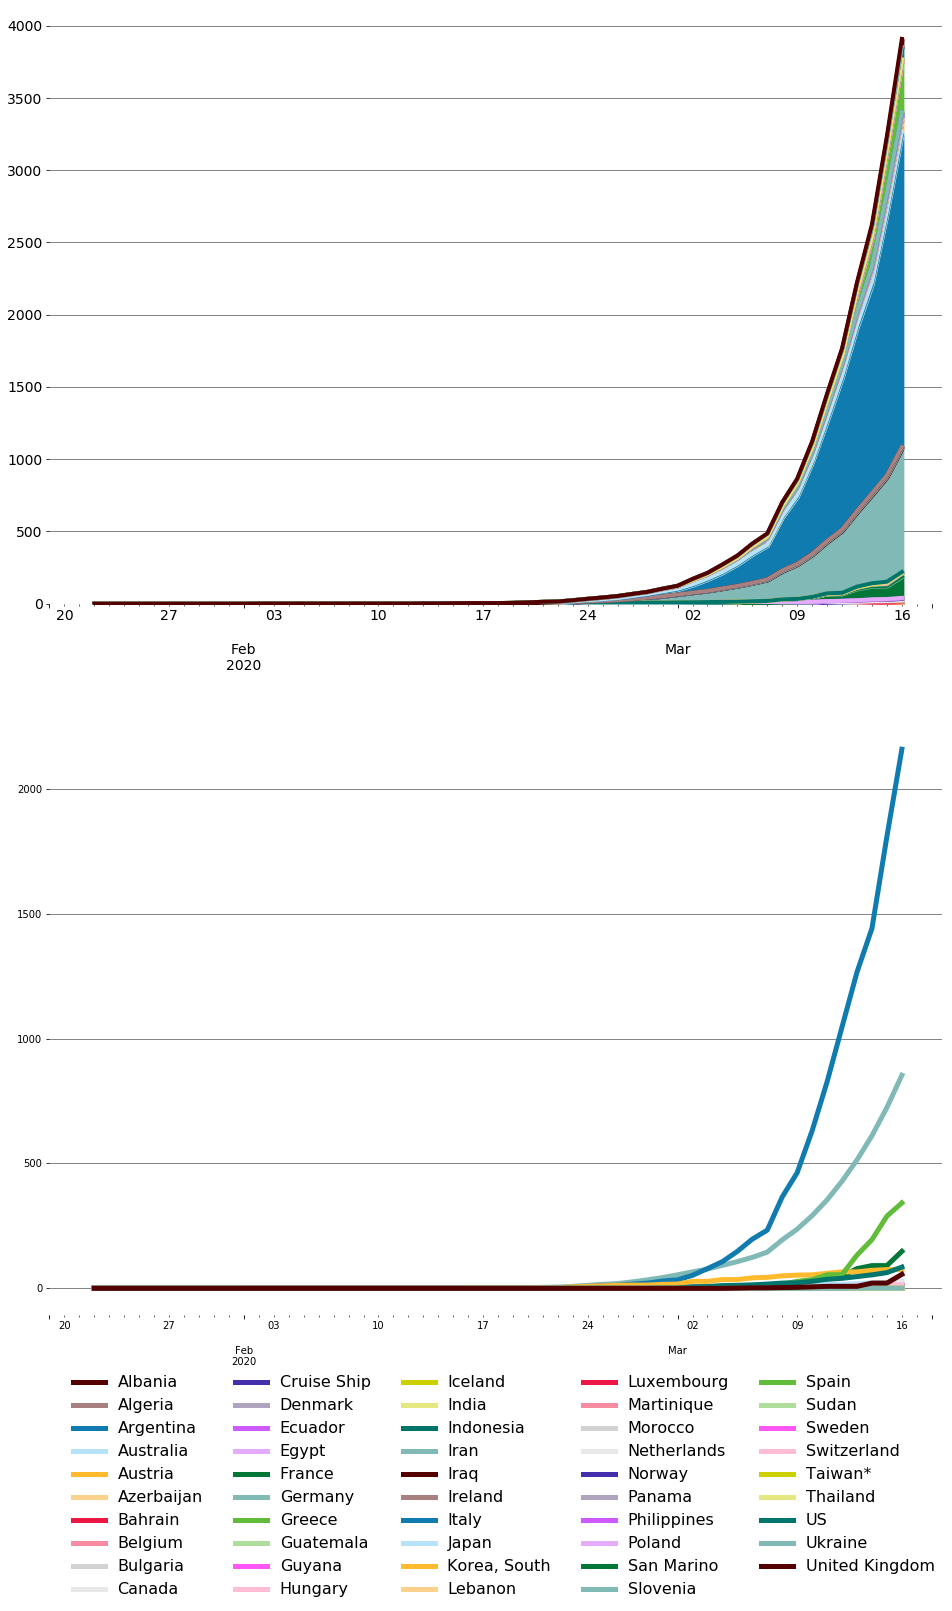

In [9]:
RoW_D3 = RoW_D2.loc[:, RoW_D2.sum(axis=0)>0]

fig = plt.figure(1, figsize=[16,24])
ax = fig.add_subplot(211)
RoW_D3.plot(kind='area', ax=ax, lw=4, fontsize=14)
ax.get_legend().remove()
plot_formatting(ax)
ax2 = fig.add_subplot(212)
RoW_D3.plot(ax=ax2, lw=5)
plot_formatting(ax2)
legend_format(ax2, cols=5, ypos=-0.5, xpos=0.01, fontsize=16)


In [11]:
RoW_D3.tail()

Country/Region,Albania,Algeria,Argentina,Australia,Austria,Azerbaijan,Bahrain,Belgium,Bulgaria,Canada,...,Slovenia,Spain,Sudan,Sweden,Switzerland,Taiwan*,Thailand,US,Ukraine,United Kingdom
2020-03-12,1,1,1,3,1,0,0,3,1,1,...,0,55,0,1,4,1,1,40,0,8
2020-03-13,1,2,2,3,1,1,0,3,1,1,...,0,133,1,1,11,1,1,47,1,8
2020-03-14,1,3,2,3,1,1,0,4,2,1,...,1,195,1,2,13,1,1,54,1,21
2020-03-15,1,4,2,3,1,1,0,4,2,1,...,1,289,1,3,14,1,1,63,1,21
2020-03-16,1,4,2,3,3,1,1,5,2,4,...,1,342,1,6,14,1,1,85,1,56


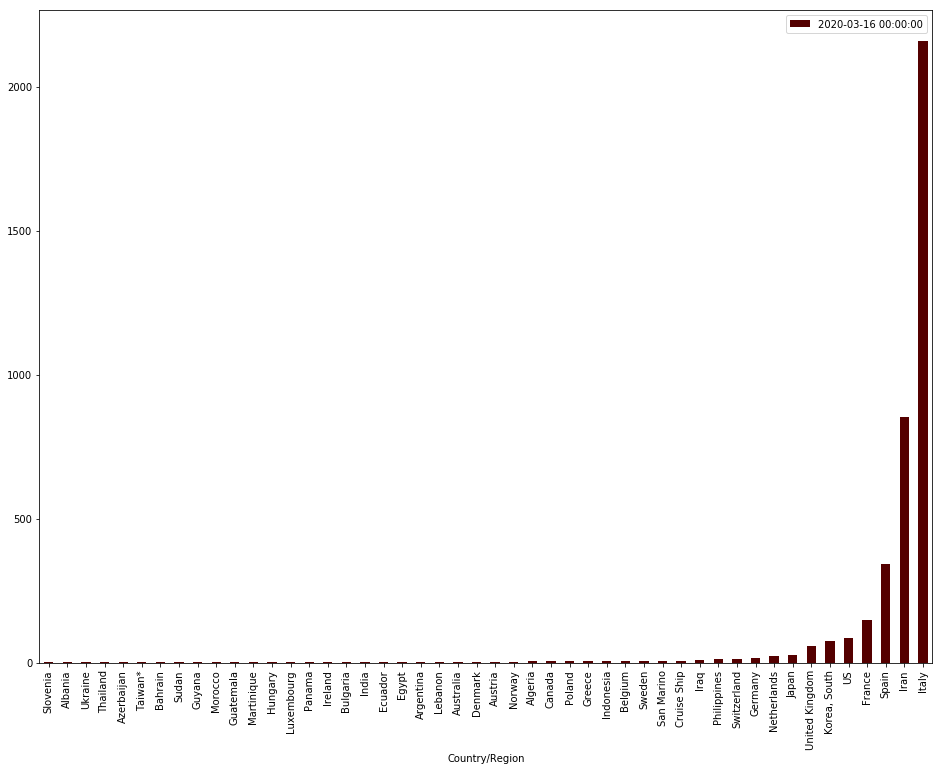

In [12]:
Cur_total_deaths = RoW_D2.tail(1).T.sort_values(by=RoW_D2.tail(1).T.columns[0])
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
Cur_total_deaths[Cur_total_deaths.sum(axis=1)>0].plot(kind='bar', ax=ax)

(0, 3000)

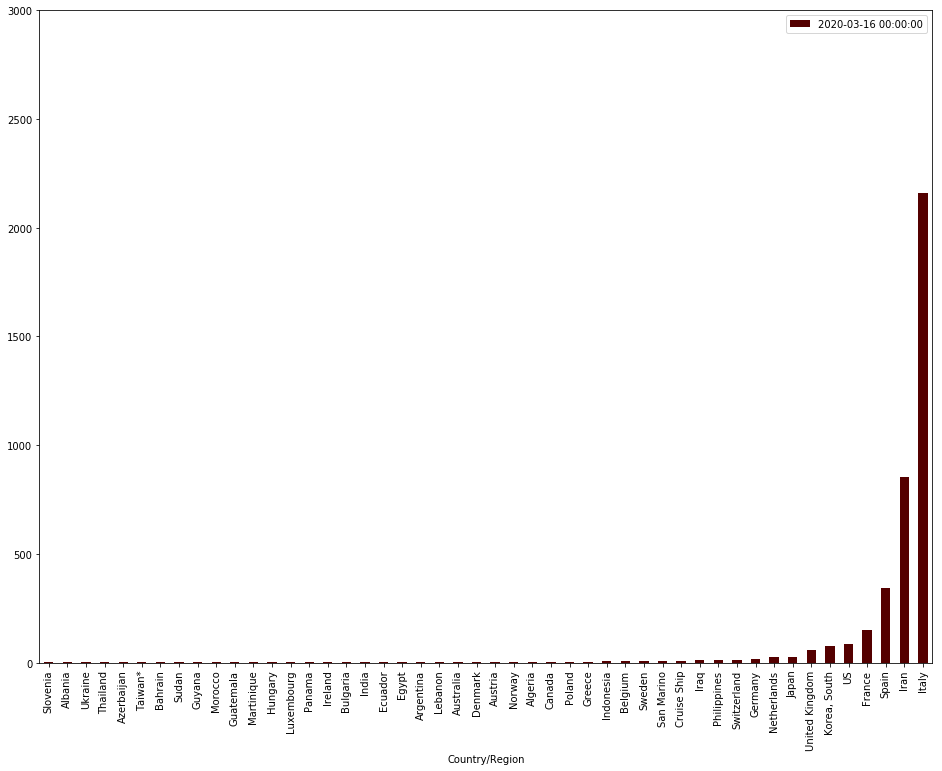

In [14]:
Cur_total_deaths = RoW_D2.tail(1).T.sort_values(by=RoW_D2.tail(1).T.columns[0])
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
Cur_total_deaths[Cur_total_deaths.sum(axis=1)>0].plot(kind='bar', ax=ax)
ax.set_ylim([0, 3000])

In [15]:
RoW_D.tail()

2020-03-12    1767.5
2020-03-13    2224.0
2020-03-14    2626.0
2020-03-15    3237.0
2020-03-16    3909.0
dtype: float64

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


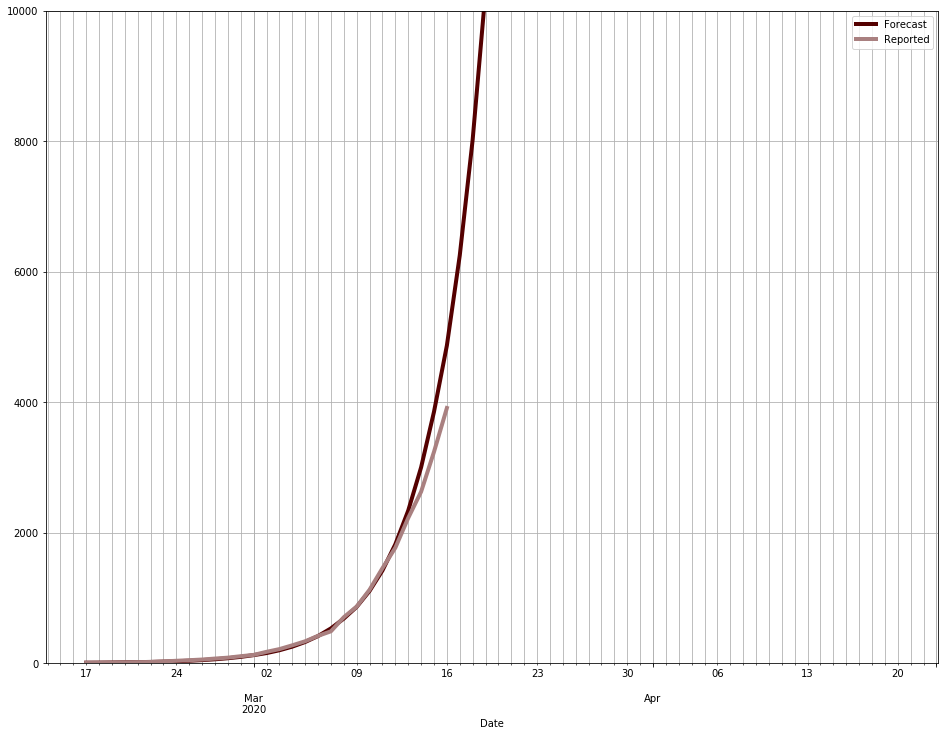

In [16]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
fit_exp(RoW_D, start_date=datetime(2020,2,17)).plot(ax=ax, lw=4)
ax.set_ylim([0, 10000])
grid('on', which='both')

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


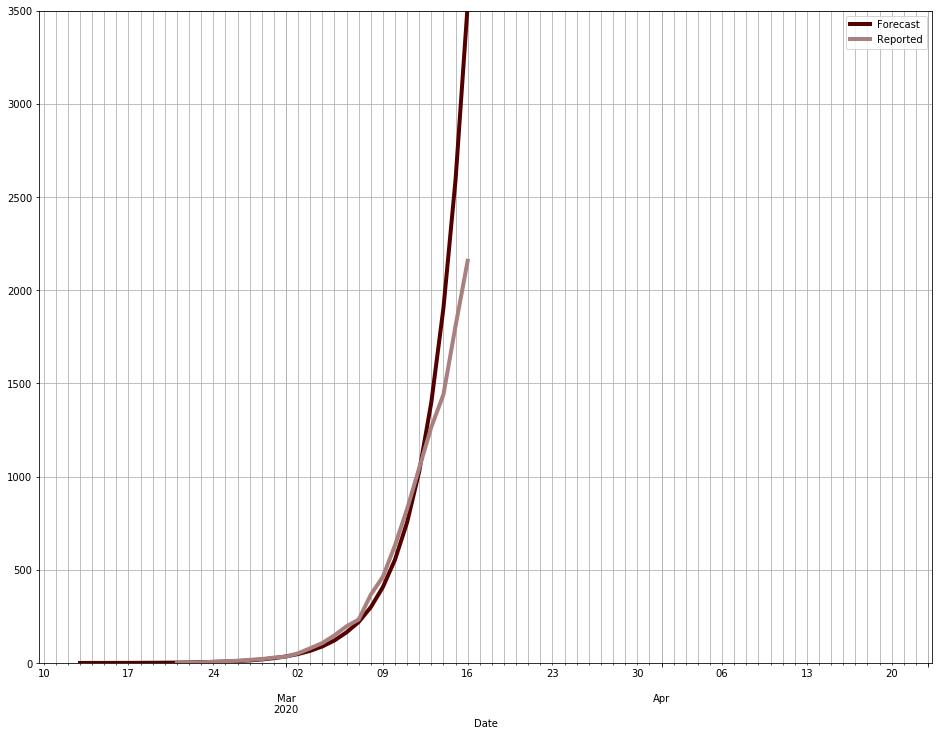

In [18]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
fit_exp(RoW_D2['Italy'], start_date=datetime(2020,2,13)).plot(ax=ax, lw=4)
ax.set_ylim([0, 3500])
ax.grid('on', which='both')

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


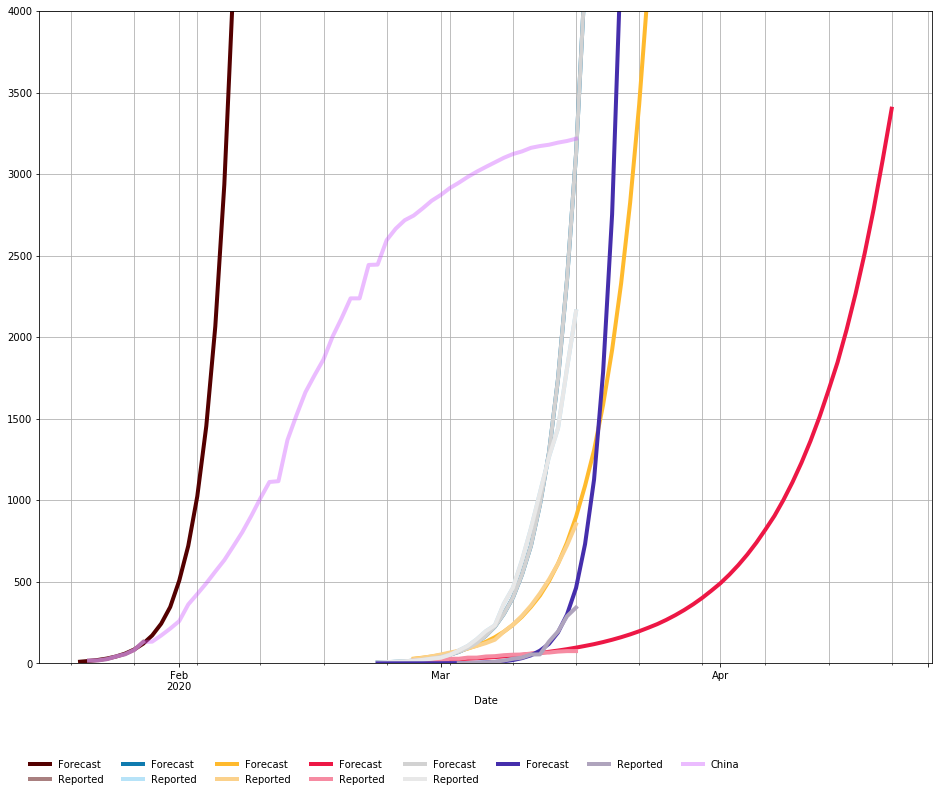

In [28]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
fit_exp(C_D[:7], start_date=datetime(2020,1,21)).plot(ax=ax, lw=4)
fit_exp(RoW_D2['Italy'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4, label='x')
fit_exp(RoW_D2['Iran'], start_date=datetime(2020,2,27)).plot(ax=ax, lw=4,)
fit_exp(RoW_D2['Korea, South'], start_date=datetime(2020,2,27)).plot(ax=ax, lw=4,)
fit_exp(RoW_D2['Italy'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4)
fit_exp(RoW_D2['Spain'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4)
#fit_exp(RoW_D2['United States'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4)
C_D.plot(ax=ax, lw=4, alpha=0.4)
ax.set_ylim([0, 4000])
ax.grid('on', which='both')
legend_format(ax, cols=8, ypos=-0.2)

[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]


[3909.0, 737473.0, 1, 0.0]


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


(0, 3500)

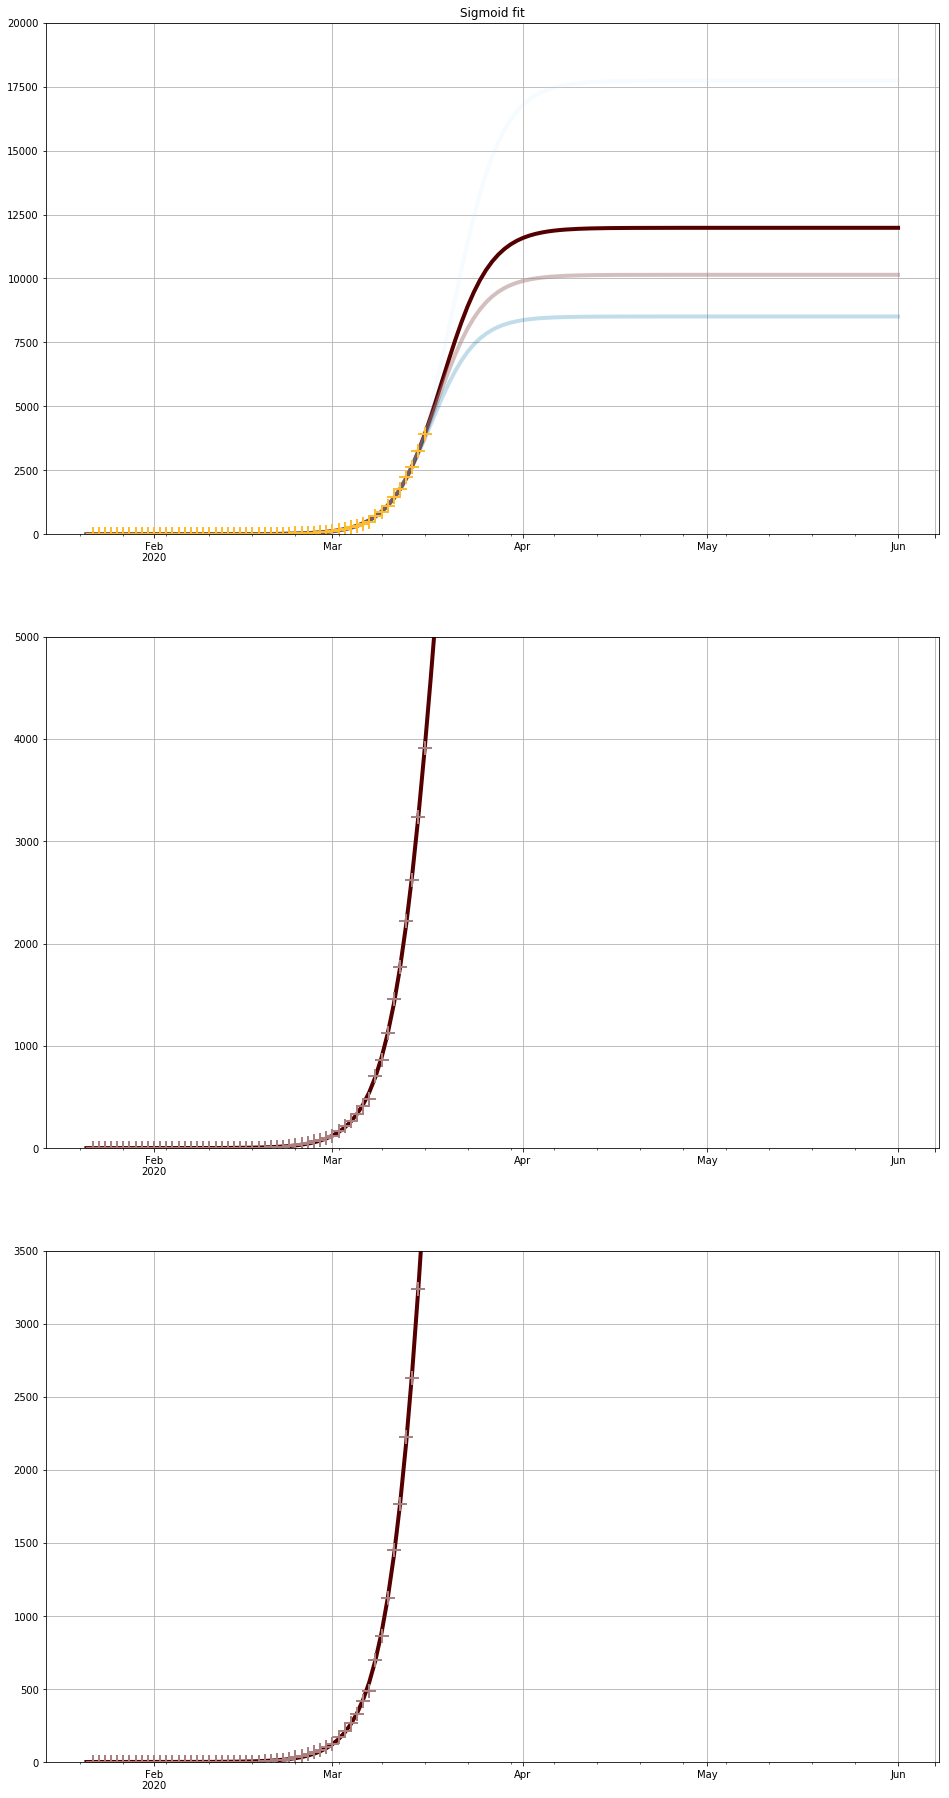

In [40]:
fig = plt.figure(1, figsize=[16,32])
ax = fig.add_subplot(311)
#fit_sigmoid(RoW_D, start_date=datetime(2020,2,1)).Forecast.plot(ax=ax, lw=4)
fs = fit_sigmoid(RoW_D, p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn1 = fit_sigmoid(RoW_D.iloc[:-1], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn2 = fit_sigmoid(RoW_D.iloc[:-2], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn3 = fit_sigmoid(RoW_D.iloc[:-3], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast

fs.index = pd.to_datetime(fs.index)
fsn1.index = pd.to_datetime(fsn1.index)
fsn2.index = pd.to_datetime(fsn2.index)
fsn3.index = pd.to_datetime(fsn3.index)

fs.plot(ax=ax, lw=4)
fsn1.plot(ax=ax, lw=4, alpha=0.5)
fsn2.plot(ax=ax, lw=4, alpha=0.25)
fsn3.plot(ax=ax, lw=4, alpha=0.125)
ax.set_title('Sigmoid fit')
fs_r = fit_sigmoid(RoW_D).Reported
fs_r.index = pd.to_datetime(fs_r.index)
fs_r.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 20000])
# ax.vlines(datetime(2020,3,10), ymin=0, ymax=2000, color='r')
# ax.vlines(datetime(2020,4,28), ymin=0, ymax=2000, color='r')
# ax.hlines(fs.max()/2, xmin=datetime(2020,1,21), xmax=datetime(2020,7,1), color='r')
# ax.vlines(datetime(2020,4,28), ymin=0, ymax=2000, color=ea.ea_s['pk1'], lw=4)
# ax.vlines(datetime(2020,2,3), ymin=0, ymax=2000, color='r')
ax2 = fig.add_subplot(312)
(fs*1).plot(ax=ax2, lw=4)

(fs_r*1).plot(ax=ax2, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 5000])
# ax2.vlines(datetime(2020,2,29), ymin=0, ymax=2000, color='r')
# ax2.vlines(datetime(2020,3,10), ymin=0, ymax=2000, color='r')
# ax2.vlines(datetime(2020,3,19, 12), ymin=0, ymax=2000, color='r')
# ax2.vlines(datetime(2020,3,29), ymin=0, ymax=2000, color='r')
# ax2.vlines(datetime(2020,4,8), ymin=0, ymax=2000, color='r')
# ax2.vlines(datetime(2020,4,18), ymin=0, ymax=2000, color='r')
# ax2.vlines(datetime(2020,5,9), ymin=0, ymax=2000, color='r')
# ax2.vlines(datetime(2020,4,28), ymin=0, ymax=2000, color=ea.ea_s['pk1'], lw=4)
# ax2.vlines(datetime(2020,2,3), ymin=0, ymax=2000, color='r')

ax3 = fig.add_subplot(313)
(fs).plot(ax=ax3, lw=4)
# ax3.vlines(datetime(2020,2,29), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,3,10), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,3,19, 12), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,3,29), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,4,8), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,4,18), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,5,9), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,4,28), ymin=0, ymax=2000, color=ea.ea_s['pk1'], lw=4)
fs_r.plot(ax=ax3, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 3500])
# ax3.vlines(datetime(2020,3,10), ymin=0, ymax=2000, color='r')
# ax3.vlines(datetime(2020,2,3), ymin=0, ymax=2000, color='r')




/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


(1000, 17500)

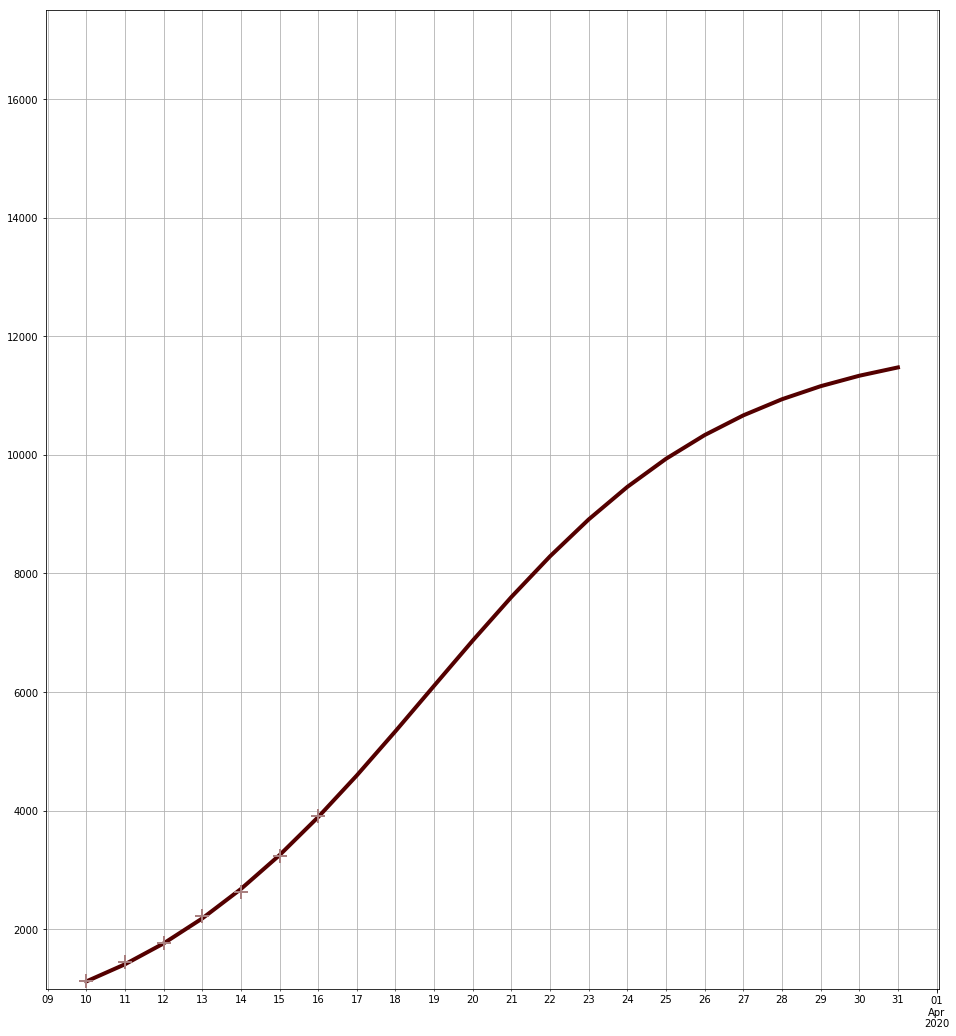

In [32]:
fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
fs["2020/3/10":"2020/3/31"].plot(ax=ax, lw=4)
fs_r["2020/3/10": "2020/3/31"].plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
grid('on', which='both')
ylim([1000, 17500])
# ax3.vlines(datetime(2020,3,10), ymin=0, ymax=2000, color='r')



In [18]:
#!git commit -a -m "Update"
#!git push djh master

In [21]:
7500000* 3500/1400000

18750.0

In [33]:
5000000*12500/7500000000

8.333333333333334